In [19]:
import numpy as np
import jax.numpy as jnp

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

# PLOTTING
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.style.use('spiffy')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mycolorpy import colorlist as mcp

from src.core.activation import SoftReLu

In [20]:
colors_targets = ['#E09F1F', '#907245']
color_fits = ['#00C9B3', '#005B4E']

In [21]:
class ExcInhMicroCircuit:
        
    wXE: float = 1.0
    wXI: float = 0.0
    wIE: float = 1.0
    wEI: float = 1.0
    
    # Solver
    dt = 1/50               # 1/tau
    n_solver = 600          # number of solver steps
    
    alpha = 5.0
    
    def __init__(self, actE, actI) -> None:
        self.actE = actE
        self.actI = actI
            
    def vectorfield(self, state, t, x, target = None):    
        ue, ui = state
        
        due = -ue - self.wIE * self.actI(ui) + self.wXE * x
        dui = -ui + self.wEI * self.actE(ue) + self.wXI * x

        if target is not None:
            out = self.actE(ue)
            error = target - out
            dui -= self.alpha * error
            
        return np.array([due, dui])
            
    def solve_euler(self, x, target = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0, 0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x)), np.zeros(len(x))])
        
        t = 0
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            
        return u
    
    def traj_euler(self, x, target = None, u0 = None):
        
        # check if x is a scalar
        if np.isscalar(x):
            u = np.array([0, 0])            
        # otherwise x is a vector
        else:
            u = np.array([np.zeros(len(x)), np.zeros(len(x))])
        
        t = 0
        us = [u]
        ts = [t]
        
        for i in range(self.n_solver):
            u = u + self.dt * self.vectorfield(u, t, x, target)
            t = t + self.dt  
            us.append(u)
            ts.append(t)
            
        return np.array(ts), np.array(us)

    def dw_exact(self, x_range, target=None):
        
        state = self.solve_euler(x_range, target=target)
        ue, ui = state
        rE = self.actE(ue)
        rI = self.actI(ui)
        dw = x_range * (self.wEI * rE - self.actI.inv(rI)) * self.actE.deriv(ue)
        
        return state, dw
    
    def dw_inv_lin(self, x_range, theta, delta, target=None):
        
        state = self.solve_euler(x_range, target=target)
        ue, ui = state
        rE = self.actE(ue)
        rI = self.actI(ui)
        dw = x_range * (self.wEI * rE - lin_model(rI, theta, delta)) * self.actE.deriv(ue)
        
        return state, dw
    
def lin_model(y, theta, delta):
    return theta + delta * y
    

In [22]:
# PARAMETERS
params_act = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 3.0
}

preact = jnp.linspace(0, 8, 1000)

# FITTING RESULTS
theta = 1.5
delta = 1.5

theta2 = 0.9
delta2 = 1.8

# INSET: Inverse activation function and linear approximation thereof

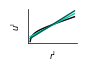

In [23]:
# MODEL
func = SoftReLu(**params_act)
act = func(preact)
deriv = func.deriv(preact)
inv = func.inv(act)
inv_lin = lin_model(act, theta, delta)
inv_lin2 = lin_model(act, theta2, delta2)

fig, ax = plt.subplots(1, 1, figsize=(0.75, 0.6))

ax.plot(act, inv, label='Inverse', lw=1, c='k')
ax.plot(act, inv_lin, label='Linear approximation', lw=1, c=color_fits[0])
ax.plot(act, inv_lin2, label='Linear approximation', lw=1, c=color_fits[1])

ax.set_xlabel(r'$r^{\mathrm{I}}$', fontsize=6)
ax.set_ylabel(r'$u^{\mathrm{I}}$', fontsize=6)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Panel A: Microcircuit with top-down control

In [24]:
params_act_E = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 3.0
}

params_act_I = {
    'scale': 1.0,
    'sharpness': 1.0,
    'shift': 3.0
}

funcE = SoftReLu(**params_act_E)
funcI = SoftReLu(**params_act_I)

model = ExcInhMicroCircuit(actE=funcE, actI=funcI)
model.wXE = np.array([1])

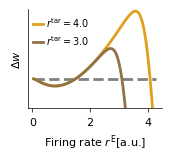

In [25]:
# Input
preact = jnp.linspace(0, 10, 100)

# Targets
target_1 = 4.0
target_2 = 3.0

state_1, dw_1 = model.dw_inv_lin(preact, theta, delta, target=target_1)
state_2, dw_2 = model.dw_inv_lin(preact, theta, delta, target=target_2)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

# First target
uE, uI = state_1
rE = model.actE(uE)
rI = model.actI(uI)
ax.plot(rE, dw_1, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_1), lw=2, c=colors_targets[0])

# Dashed line
ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)

# Second target
uE, uI = state_2
rE = model.actE(uE)
rI = model.actI(uI)

ax.plot(rE, dw_2, label=r'$r^{\mathrm{tar}} = $' + '{}'.format(target_2), lw=2, c=colors_targets[1])

ax.set_yticks([])
ax.set_ylim(-5, 12)

ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$'+ '[a.u.]')
ax.set_ylabel(r'$\Delta w$')

ax.legend(fontsize=7, loc='upper left', bbox_to_anchor=(0.0, 1.0), frameon=False, borderpad=0.1, handletextpad=0.3, handlelength=1.0)

plt.show()

# Panel B: Microcircuit without target

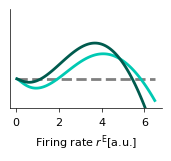

In [26]:
# Input
preact = jnp.linspace(0, 13, 100)

state, dw = model.dw_inv_lin(preact, theta, delta, target=None)
state2, dw2 = model.dw_inv_lin(preact, theta2, delta2, target=None)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

uE, uI = state
rE = model.actE(uE)
rI = model.actI(uI)
ax.plot(rE, dw, label='dw', lw=2, c=color_fits[0])

uE, uI = state2
rE = model.actE(uE)
rI = model.actI(uI)
ax.plot(rE, dw2, label='dw', lw=2, c=color_fits[1])

# Dashed line
ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)

ax.set_yticks([])
ax.set_ylim(-5, 12)
ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$'+ '[a.u.]')

plt.show()

# Panel C: Isolated Neuron

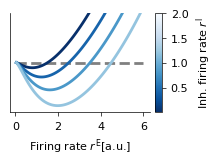

In [27]:
preact = jnp.linspace(0, 9, 100)

# Figure
fig, ax = plt.subplots(1, 1, figsize=(1.6, 1.5))

list_rI = np.linspace(0.01, 2, 4)
colormap = mcp.gen_color(cmap='Blues_r', n=len(list_rI)+2)
labels = list_rI

uE = preact
rE = model.actE(uE)

for rI_idx, rI in enumerate(list_rI):
    dw = preact * model.actE.deriv(uE) * (rE - lin_model(rI, theta, delta))
    ax.plot (rE, dw, label=labels[rI_idx], color=colormap[rI_idx], lw=2)
ax.hlines(0, rE.min(), rE.max(), lw=2, linestyle='--', color='gray', zorder=0)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=list_rI.min(), vmax=list_rI.max())
cbarMap = mpl.cm.ScalarMappable(cmap=mpl.cm.Blues_r, norm = norm)
fig.colorbar(cbarMap, cax=cax, orientation='vertical')
cax.set_ylabel('Inh. firing rate ' + r'$r^{\mathrm{I}}$')

ax.set_xlabel('Firing rate ' + r'$r^{\mathrm{E}}$' + '[a.u.]')
#ax.set_ylabel(r'$\Delta w$')

ax.set_yticks([])
ax.set_ylim(-12, 12)

plt.show()